# Generate a random symmetric or euclidean graph

Given for the task

In [126]:
from random import randint, choice, shuffle, random
from pprint import pprint
from itertools import permutations
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt
from time      import time
import matplotlib.pyplot as plt
import copy
import numpy as np

MAX_DISTANCE = 100

def random_symmetric_graph(n):
    ''' Symmetric adjacency matrix of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i+1,n):
            v = randint(1,MAX_DISTANCE)
            dist_matrix[i][j] = v
            dist_matrix[j][i] = v
    return dist_matrix

def random_euclidean_graph(n):
    ''' Symmetric adjacency matrix of a Euclidean graph of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    points = []
    for p in range(n):
        x,y = randint(0,MAX_DISTANCE), randint(0,MAX_DISTANCE)
        points.append((x,y))
    for i in range(n):
        p1 = points[i]
        for j in range(i+1,n):
            p2 = points[j]
            distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
            dist_matrix[i][j] = distance
            dist_matrix[j][i] = distance
    return dist_matrix

def show(G):
    ''' Show adjacency matrix. Useful for debugging. '''
    n = len(G)
    r = "     "
    for i in range(n):
        r += f'{i:4}'
    r += '\n    -'+'-'*(4*n)+'\n'
    for i in range(n):
        r += f'{i:2} | '
        for j in range(n):
            r += f'{G[i][j]:4}'
        r += '\n'
    r = r.replace('inf', '  ∞')
    print(r)

def cost(G, cycle):
    ''' Calculate the cost of the given cycle '''
    c = 0
    n = len(G)
    for i in range(n):
        a = cycle[i]
        b = cycle[(i+1)%n]
        c += G[a][b]
    return c

J = random_euclidean_graph(5)
G = random_symmetric_graph(5)
show(J)
show(G)

        0   1   2   3   4
    ---------------------
 0 |    ∞86.9770084562581373.4302390027432894.0212741883452777.15568676384133
 1 | 86.97700845625813   ∞21.47091055358388833.2415402771893243.840620433565945
 2 | 73.4302390027432821.470910553583888   ∞24.16609194718914524.186773244895647
 3 | 94.0212741883452733.2415402771893224.166091947189145   ∞22.02271554554524
 4 | 77.1556867638413343.84062043356594524.18677324489564722.02271554554524   ∞

        0   1   2   3   4
    ---------------------
 0 |    ∞  30  98  72  23
 1 |   30   ∞  31  60  68
 2 |   98  31   ∞  46  68
 3 |   72  60  46   ∞  20
 4 |   23  68  68  20   ∞



# Create a generation of x possible routes

With a given graph, randomly generate a 'population' of possible routes

Code

In [127]:
G = random_symmetric_graph(5)
population = 6
print("\nMatrice")
show(G)

'''Used the shuffle function to generate a 'population' sized amount'''
'''of possible routes'''

def createGen(matrix, population):
    route = []
    genZ = [None] * int(population)
    for i in range(0,len(matrix)):
        route.append(i)
    for j in range(0,int(population)):
        if j == 0:
            np.random.shuffle(route)
            newRoute = route[:]
            genZ[j] = newRoute
        else:
            np.random.shuffle(route)
            for h in range(0,len(genZ)):
                if route == genZ[h]:
                    np.random.shuffle(route)
            newRoute = route[:]
            genZ[j] = newRoute
    return genZ

print("Genenration 0 of routes")        
print(createGen(G,6))


Matrice
        0   1   2   3   4
    ---------------------
 0 |    ∞  89   1  91   3
 1 |   89   ∞  32  88  11
 2 |    1  32   ∞   5  14
 3 |   91  88   5   ∞  61
 4 |    3  11  14  61   ∞

Genenration 0 of routes
[[2, 0, 1, 4, 3], [2, 3, 1, 0, 4], [1, 3, 4, 2, 0], [1, 3, 2, 4, 0], [0, 1, 2, 4, 3], [1, 2, 3, 0, 4]]


# Calculate the length of these routes

We use the values in the graph to create a new list of positiv integer which represents, for each route, the sum of all its edges cost for a loop (TSP), the travelling distance.

Code

In [128]:
def fitness(matrix, routes):
    fitnessRanking = []
    for i in range(0, len(routes)):
        fitnessTotal = 0
        for j in range(0,len(matrix)):
            if j + 1 < len(matrix):
                fitnessTotal = fitnessTotal + int(matrix[routes[i][j]][routes[i][j+1]])
            else:
                fitnessTotal = fitnessTotal + int(matrix[routes[i][j]][routes[i][0]])
        fitnessRanking.append(fitnessTotal)
    return fitnessRanking

show(G)
print("Genenration 0")        
genZ = createGen(G,6)
print(genZ)
print("Fitness")
ranking = fitness(G, genZ)
print(ranking)

        0   1   2   3   4
    ---------------------
 0 |    ∞  89   1  91   3
 1 |   89   ∞  32  88  11
 2 |    1  32   ∞   5  14
 3 |   91  88   5   ∞  61
 4 |    3  11  14  61   ∞

Genenration 0
[[2, 3, 4, 1, 0], [0, 2, 4, 3, 1], [1, 2, 3, 0, 4], [3, 1, 2, 4, 0], [0, 4, 2, 1, 3], [3, 2, 1, 4, 0]]
Fitness
[167, 253, 142, 228, 228, 142]


# Choose the parents for mating with Elitism

We then find the two routes with the lowest traveling distance by copying and sorting the rank list into a new list to find the top two.
Then we find the position of them in the ranking list and in so in the routes list

Code

In [129]:
def first(ranking, routes):
    sortedRank = ranking[:]
    sortedRank.sort()
    firstPos = ranking.index(sortedRank[0])
    firstRoute = routes[firstPos]
    return firstRoute

def second(ranking, routes):
    sortedRank = ranking[:]
    sortedRank.sort()
    secondPos = ranking.index(sortedRank[1])
    secondRoute = routes[secondPos]
    return secondRoute
    
win = first(ranking, genZ)
print(win)
win2 = second(ranking, genZ)
print(win2)
    

[1, 2, 3, 0, 4]
[1, 2, 3, 0, 4]


# Breeding

We then breed the those two routes together to create a whole new generation of routes.
To do so we take a random segment of random lentgh of the first parent and then put into the child (same segment in same position).
Then we fill in from next index in the child with the second parents nodes.

Code

In [130]:
def breed(parent1, parent2, population):
    nextGen = []
    
    for i in range(0,population):
        child = []
        childP1 = []
        childP2 = []
    
    
        geneA = int(np.random.random() * len(parent1))
        geneB = int(np.random.random() * len(parent1))
    
        startGene = min(geneA, geneB)
        endGene = max(geneA, geneB)
    
        for i in range(startGene, endGene):
            childP1.append(parent1[i])
        
        childP2 = [item for item in parent2 if item not in childP1]
        child = childP1 + childP2
        nextGen.append(child)
    
    return nextGen
    
nextGen = breed(win, win2, population)
print(nextGen)

[[1, 2, 3, 0, 4], [1, 2, 3, 0, 4], [1, 2, 3, 0, 4], [1, 2, 3, 0, 4], [1, 2, 3, 0, 4], [1, 2, 3, 0, 4]]


# Mutation

We also randomly mutate each child route with a decided rate.
We apply it to a whole gen to make it easier.

Code

In [131]:
'''Mutation rate set to 5%'''

mutation = 0.05

def mutate(child, mutationRate):
    for swapped in range(len(child)):
        if(np.random.random() <= mutationRate):
            swapWith = int(np.random.random() * len(child))
            
            node1 = child[swapped]
            node2 = child[swapWith]
            
            child[swapped] = node2
            child[swapWith] = node1
    return child

def mutateGen(currentGen, mutationRate, population):
    mutatedGen = []
    
    for child in range(0, population):
        mutatedChild = mutate(currentGen[child], mutationRate)
        mutatedGen.append(mutatedChild)
        
    return mutatedGen

mutatedGen = mutateGen(nextGen,mutation, population)
print(mutatedGen)

[[1, 2, 3, 0, 4], [1, 2, 3, 0, 4], [4, 2, 3, 0, 1], [1, 2, 3, 0, 4], [2, 1, 3, 0, 4], [1, 2, 3, 0, 4]]


# Repeat

A function to be able to repeat this whole cycle of ranking, breeding and mutating to create a new generation

Code

In [132]:

def nextGeneration(mutatedGen, population, mutationRate):
    rank = fitness(G, mutatedGen)
    parent1 = first(rank, mutatedGen)
    parent2 = second(rank, mutatedGen)
    currentGen = breed(parent1, parent2, population)
    nextGeneration = mutateGen(currentGen, mutationRate, population)
    return nextGeneration

print(nextGeneration(mutatedGen, population, mutation))

[[1, 2, 3, 0, 4], [1, 2, 3, 0, 4], [2, 3, 1, 0, 4], [1, 2, 3, 0, 4], [3, 0, 1, 2, 4], [2, 1, 3, 0, 4]]


# Evolution

Allows us to see the evolution of the routes after x generations, starting by showing us the first best route with its value and finishing by showing us the new best one.

Code

In [133]:
def geneticAlgorithm(population, matrix, mutationRate, generations):
    result = []
    gen = createGen(matrix, population)
    rank = fitness(matrix, gen)
    rank.sort()
    print("Initial best route: ")
    print(rank[0])
    initBestRouteVal = rank[0]
    bestRouteVal = initBestRouteVal
    print(first(rank, gen))
    initBestRoute = first(rank, gen)
    bestRoute = initBestRoute
    result.append(rank[0])
    
    for i in range(0, int(generations)):
        gen = nextGeneration(gen, population, mutationRate)
        rank = fitness(G, gen)
        rank.sort()
        result.append(rank[0])
        if rank[0] < bestRouteVal:
            bestRouteVal = rank[0]
            bestRoute = first(rank, gen)
            
    print("\nFinal best route: ")
    print(bestRouteVal)
    print(bestRoute)
    
    print("\nImprovement")
    print(round((initBestRouteVal - bestRouteVal) / (initBestRouteVal), 4) * 100, '%')
    
    return (result)

bestRoute = geneticAlgorithm(population, G, mutation, 10)

Initial best route: 
167
[4, 1, 0, 3, 2]

Final best route: 
108
[3, 4, 1, 0, 2]

Improvement
35.33 %


# Main Code

To test the whole code.
Can change values to see different effects.

MAX_DISTANCE
100

Matrix
        0   1   2   3   4   5   6   7   8   9  10  11  12  13  14
    -------------------------------------------------------------
 0 |    ∞  83  19  45  38   6  82  34  71  57  79  27  81  21  38
 1 |   83   ∞  48  42  45  61  83  51  47  63  55  77  90  21  86
 2 |   19  48   ∞  86  26  58  27  88  98  62  90  37  50  67  22
 3 |   45  42  86   ∞  35  35  37  33  40  64  22 100  80  26  58
 4 |   38  45  26  35   ∞   4  61  68  53  81  63  65  27  20  35
 5 |    6  61  58  35   4   ∞  94  49  57  61   2  67  18  51  96
 6 |   82  83  27  37  61  94   ∞  90  76  82  52   4  78   9  10
 7 |   34  51  88  33  68  49  90   ∞  43  46  75  52  56  39  85
 8 |   71  47  98  40  53  57  76  43   ∞  35  74   1  44  62  48
 9 |   57  63  62  64  81  61  82  46  35   ∞   2  73  27  95  83
10 |   79  55  90  22  63   2  52  75  74   2   ∞  82  55  76   9
11 |   27  77  37 100  65  67   4  52   1  73  82   ∞  91  20   5
12 |   81  90  50  80  27  18  78  56  44  27  55  

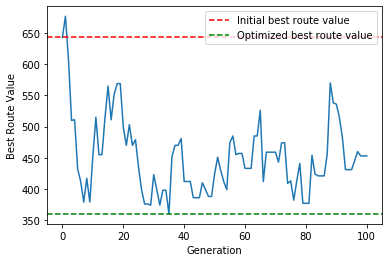

In [134]:
print("MAX_DISTANCE")
MAX_DISTANCE = 100
print(MAX_DISTANCE)

J = random_euclidean_graph(15)
G = random_symmetric_graph(15)
print("\nMatrix")
show(G)

print("\nPopulation")
population = 10
print(population)

print("\nMutation in %")
mutation=0.05
print(mutation)

print("\nAmount of generations created")
generations = 100
print(generations)

print("\nRunning ------------------------\n")
results = geneticAlgorithm(population, G, mutation, generations)


print("\n-----------------------\n")

print("Improvement over Time Graph")
def graph(results):
    bestRoute = results[:]
    bestRoute.sort()
    bestRoute = bestRoute[0]
    genList = []
    for i in range(0,len(results)):
        genList.append(i)
    plt.plot(genList, results)
    line_init = plt.axhline(y=results[0], color='r', linestyle='--')
    line_min = plt.axhline(y=bestRoute, color='g', linestyle='--')
    plt.legend([line_init, line_min], ['Initial best route value', 'Optimized best route value'])
    plt.ylabel('Best Route Value')
    plt.xlabel('Generation')
    plt.show()
    
graph(results)
    

Source:
* https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35
*  https://www.geeksforgeeks.org/traveling-salesman-problem-using-genetic-algorithm/ (in C++)
* http://www.theprojectspot.com/tutorial-post/applying-a-genetic-algorithm-to-the-travelling-salesman-problem/5
* https://www.youtube.com/watch?v=XP8R0yzAbdo